Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Data Exploration - Sales Data

* Data Exploration can be mainly used in Data Preprocessing, Feature Engineering stages
* About the source data: https://www.kaggle.com/c/rossmann-store-sales/data?select=store.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(10)

In [2]:
df = pd.read_pickle('luigi_pipeline/output/preprocessed_data.pkl')
print(df.shape)

df.head()

(693861, 18)


,Store,Date,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2015-07-31,2,0,1270.0,9,2008,0,-1,-1,-1,5,5263,555,1,1,0,1
1,1,2015-07-30,2,0,1270.0,9,2008,0,-1,-1,-1,4,5020,546,1,1,0,1
2,1,2015-07-29,2,0,1270.0,9,2008,0,-1,-1,-1,3,4782,523,1,1,0,1
3,1,2015-07-28,2,0,1270.0,9,2008,0,-1,-1,-1,2,5011,560,1,1,0,1
4,1,2015-07-27,2,0,1270.0,9,2008,0,-1,-1,-1,1,6102,612,1,1,0,1


In [3]:
def plot_num_cols_distribution(df, n_rows, n_cols, figsize=(20, 10)):
    plt.rcParams.update({'font.size': 20})
    
    i = 0
    fig=plt.figure(figsize=figsize)
    
    for col in df.columns:
        i += 1
        ax=fig.add_subplot(n_rows,n_cols,i) 
        
        sns.kdeplot(df[col].values, color='green', label=col)
        
        plt.legend(loc='best')
        plt.title(f'Distribution of {col}')
        plt.xlabel(f'Values of {col}')
        plt.ylabel('Density')
    fig.tight_layout()
    plt.show()
    
    
def get_num_cols_percentile(df):
    dct = {}
    idx = 0

    for col in df.columns:
        idx += 1
        dct[idx] = {'col': col,
                    'min': np.nanpercentile(df[col], 0), 'perct1': np.nanpercentile(df[col], 1),
                    'perct5': np.nanpercentile(df[col], 5), 'perct25': np.nanpercentile(df[col], 25),
                    'perct50': np.nanpercentile(df[col], 50), 'perct75': np.nanpercentile(df[col], 75),
                    'perct90': np.nanpercentile(df[col], 90), 'perct99': np.nanpercentile(df[col], 99),
                    'perct99.9': np.nanpercentile(df[col], 99.9), 'max': np.nanpercentile(df[col], 100)}
    dist_df = pd.DataFrame(dct).T
    dist_df = dist_df[['col', 'min', 'perct1', 'perct5', 'perct25', 'perct50', 'perct75',
                       'perct90', 'perct99', 'perct99.9', 'max']]
    return dist_df

## Check Forecast Target

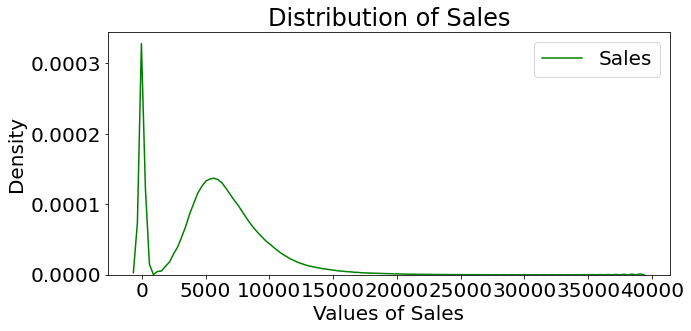

In [4]:
plot_num_cols_distribution(df[['Sales']], n_rows=1, n_cols=1, figsize=(10, 5))

In [5]:
target_dist = get_num_cols_percentile(df[['Sales']])
target_dist

,col,min,perct1,perct5,perct25,perct50,perct75,perct90,perct99,perct99.9,max
1,Sales,0,0,0,3680,5743,7890,10370,17040.4,24181.3,38722


## Feature Univariate Analysis

* Missing values
* Constant Features
* Distribution, Outliers

In [6]:
def get_close_constant_cols(df, threshold=0.99):
    constant_cols = []
    
    for col in df.columns:
        if max(df[col].value_counts())/np.sum(df[col].value_counts()) >= threshold:
            constant_cols.append(col)
    return constant_cols


def plot_cat_feature_distribution(df, n_rows, n_cols, figsize=(10, 5)):
    plt.rcParams.update({'font.size': 20})
    i = 0
    fig=plt.figure(figsize=figsize)
    for feature in df.columns:
        i += 1
        ax=fig.add_subplot(n_rows,n_cols,i) 
        axes = plt.gca()
        
        ct_df = df[feature].value_counts().sort_index()

        x_values = ct_df.index.values
        x_pos = np.arange(len(x_values))
        y_values = ct_df.values
        plt.bar(x_pos, y_values, align='center', alpha=0.5, color='green')
        plt.xticks(x_pos, x_values, rotation='30')
        plt.xlabel('Distinct Categorical Value')
        plt.ylabel('Value Count')
        plt.title(feature)

        rects = axes.patches
        total_ct = sum(y_values)

        for v, count in zip(rects, y_values):
            height = v.get_height()
            axes.text(v.get_x() + v.get_width() / 2, height/2, str(round(count*100.0/total_ct, 2))+'%',
                    ha='center', va='bottom')
    fig.tight_layout()
    plt.show()

In [7]:
# check missing values
pd.DataFrame(df.isnull().sum()).T

,Store,Date,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# check constant features
constant_cols = get_close_constant_cols(df)
print(constant_cols)

[]


In [9]:
cat_cols = [col for col in df.columns if str(df.dtypes[col]) == 'category' if col not in ['Store', 'Quarter']]
print(len(cat_cols), cat_cols)
num_cols = [col for col in df.columns if col not in cat_cols and col not in ['Date', 'Sales', 'Store', 'Quarter']]
print(len(num_cols), num_cols)

15 ['Year', 'Month', 'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
2 ['CompetitionDistance', 'Customers']


761
942


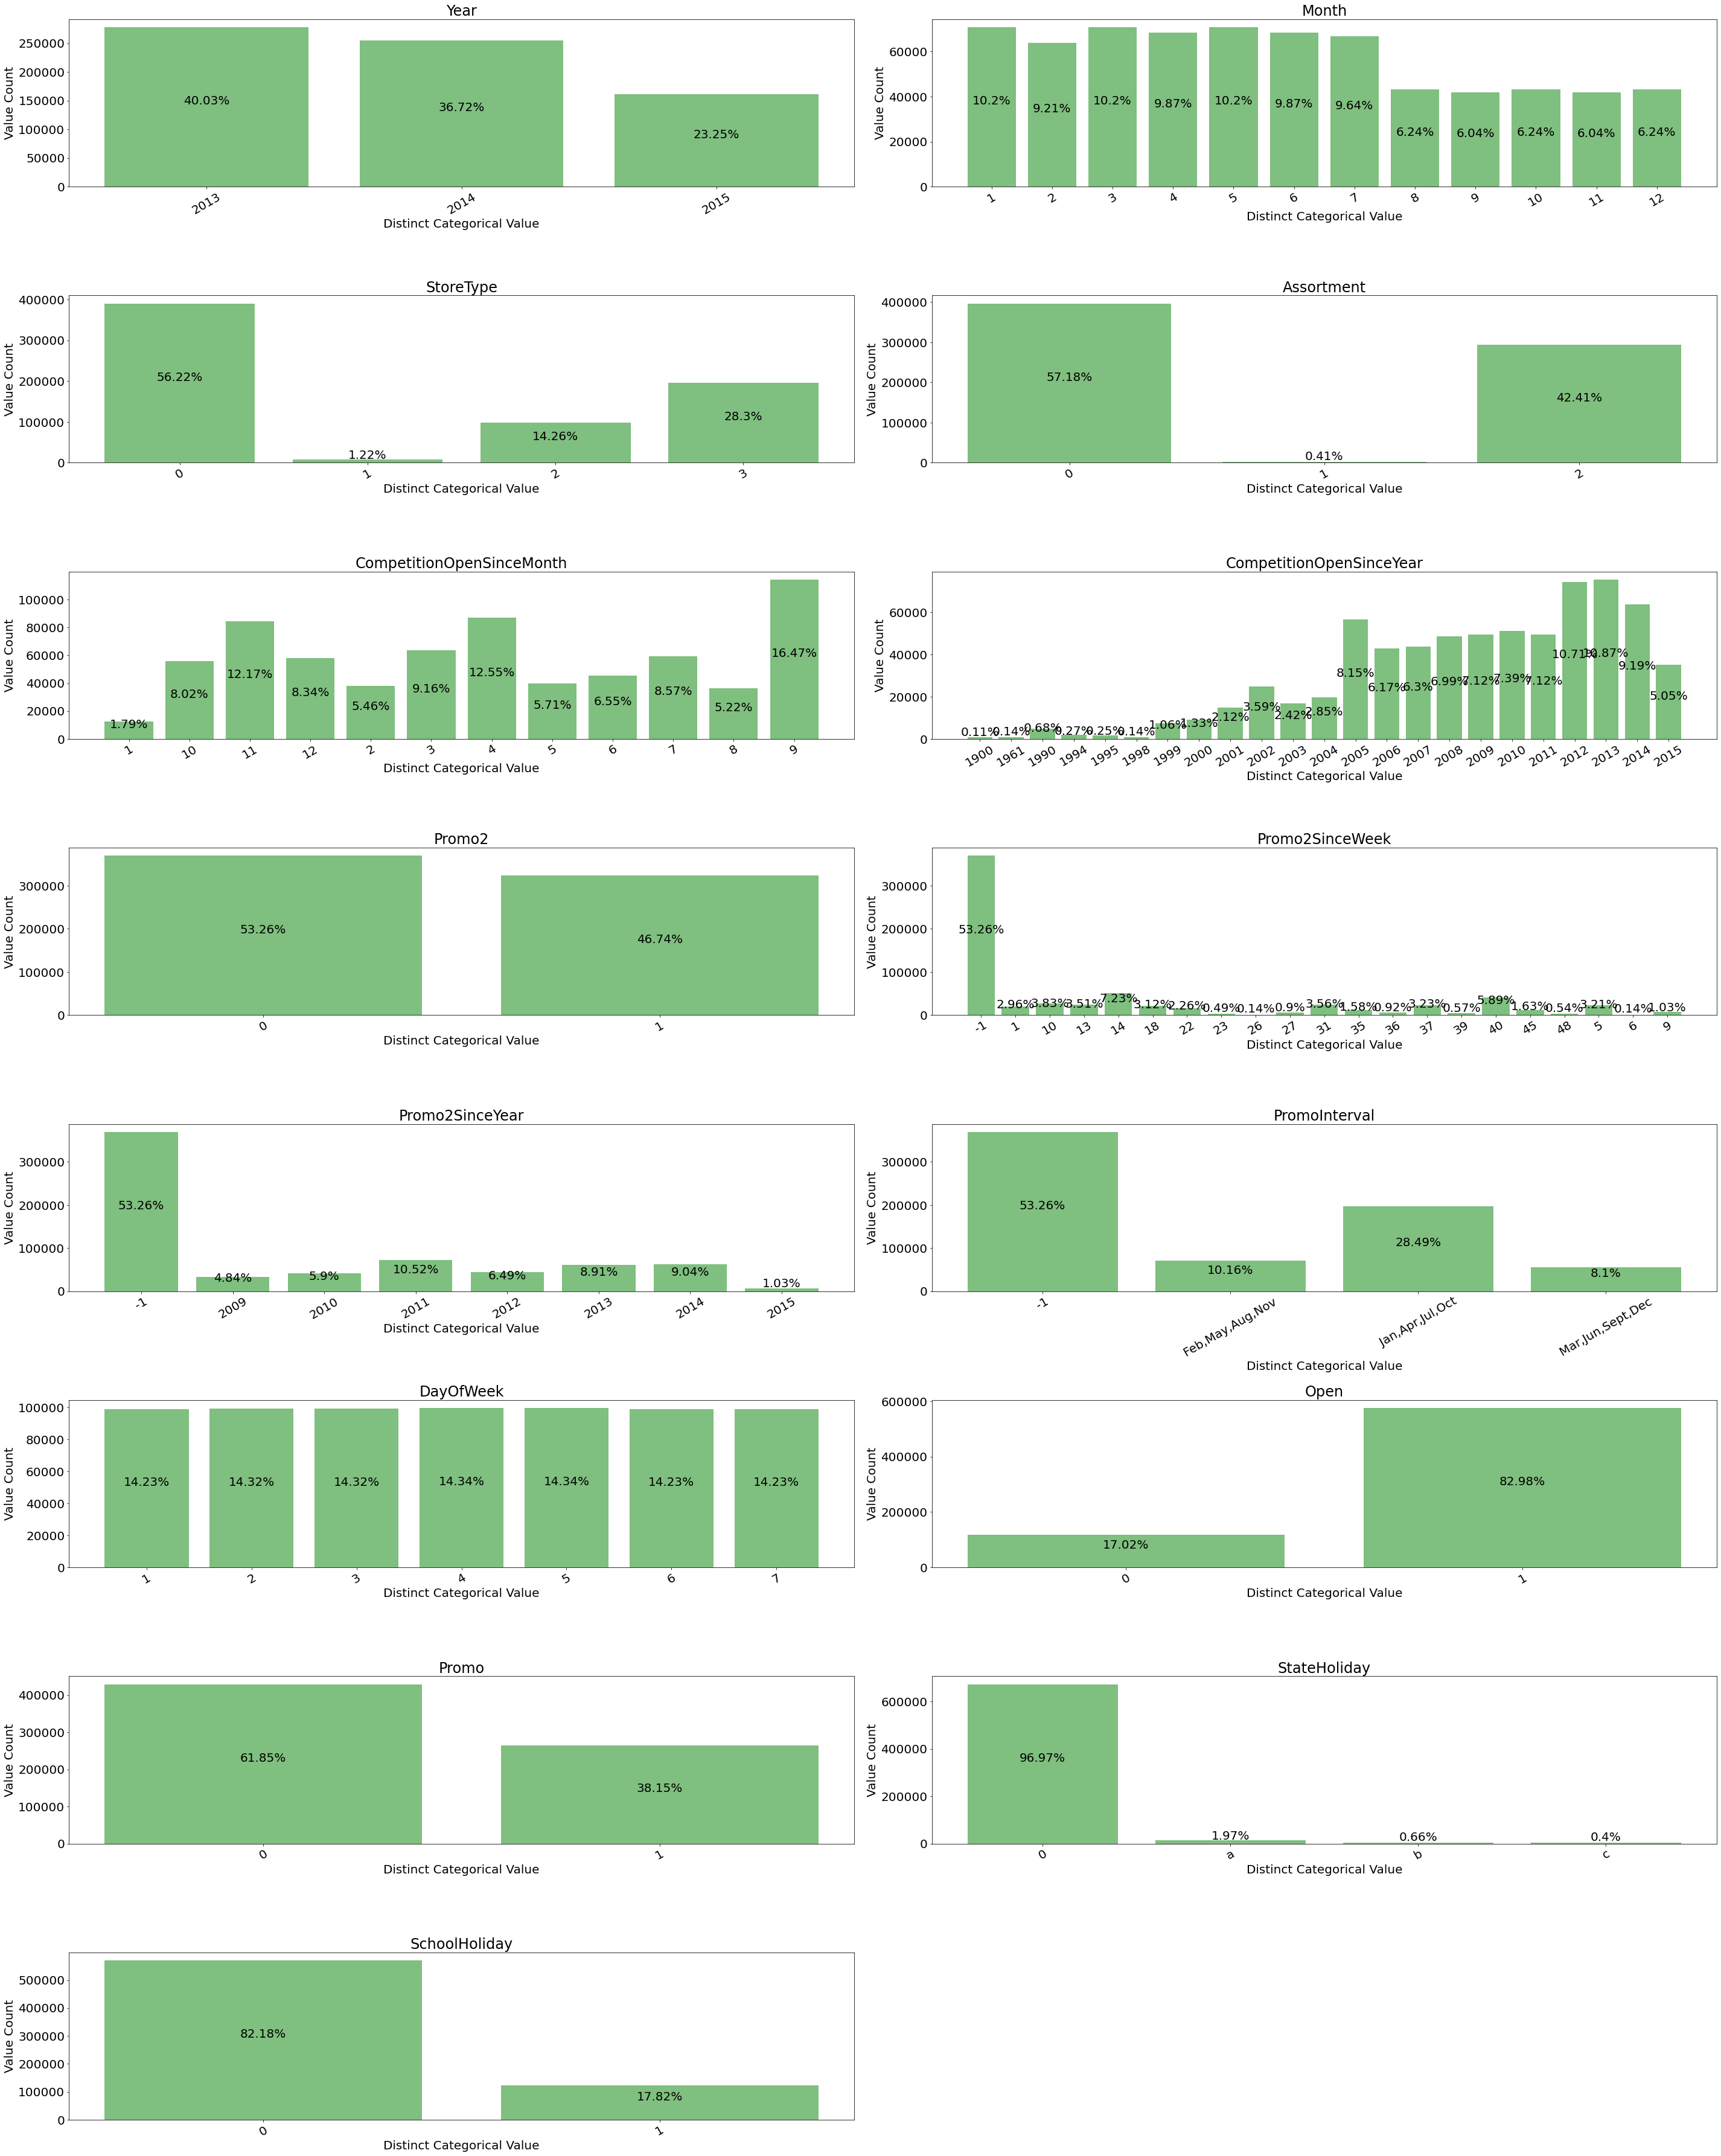

In [10]:
# check categorical features' distributions
print(df['Store'].nunique())
print(df['Quarter'].nunique())

plot_cat_feature_distribution(df[cat_cols], n_rows=8, n_cols=2, figsize=(40,50))

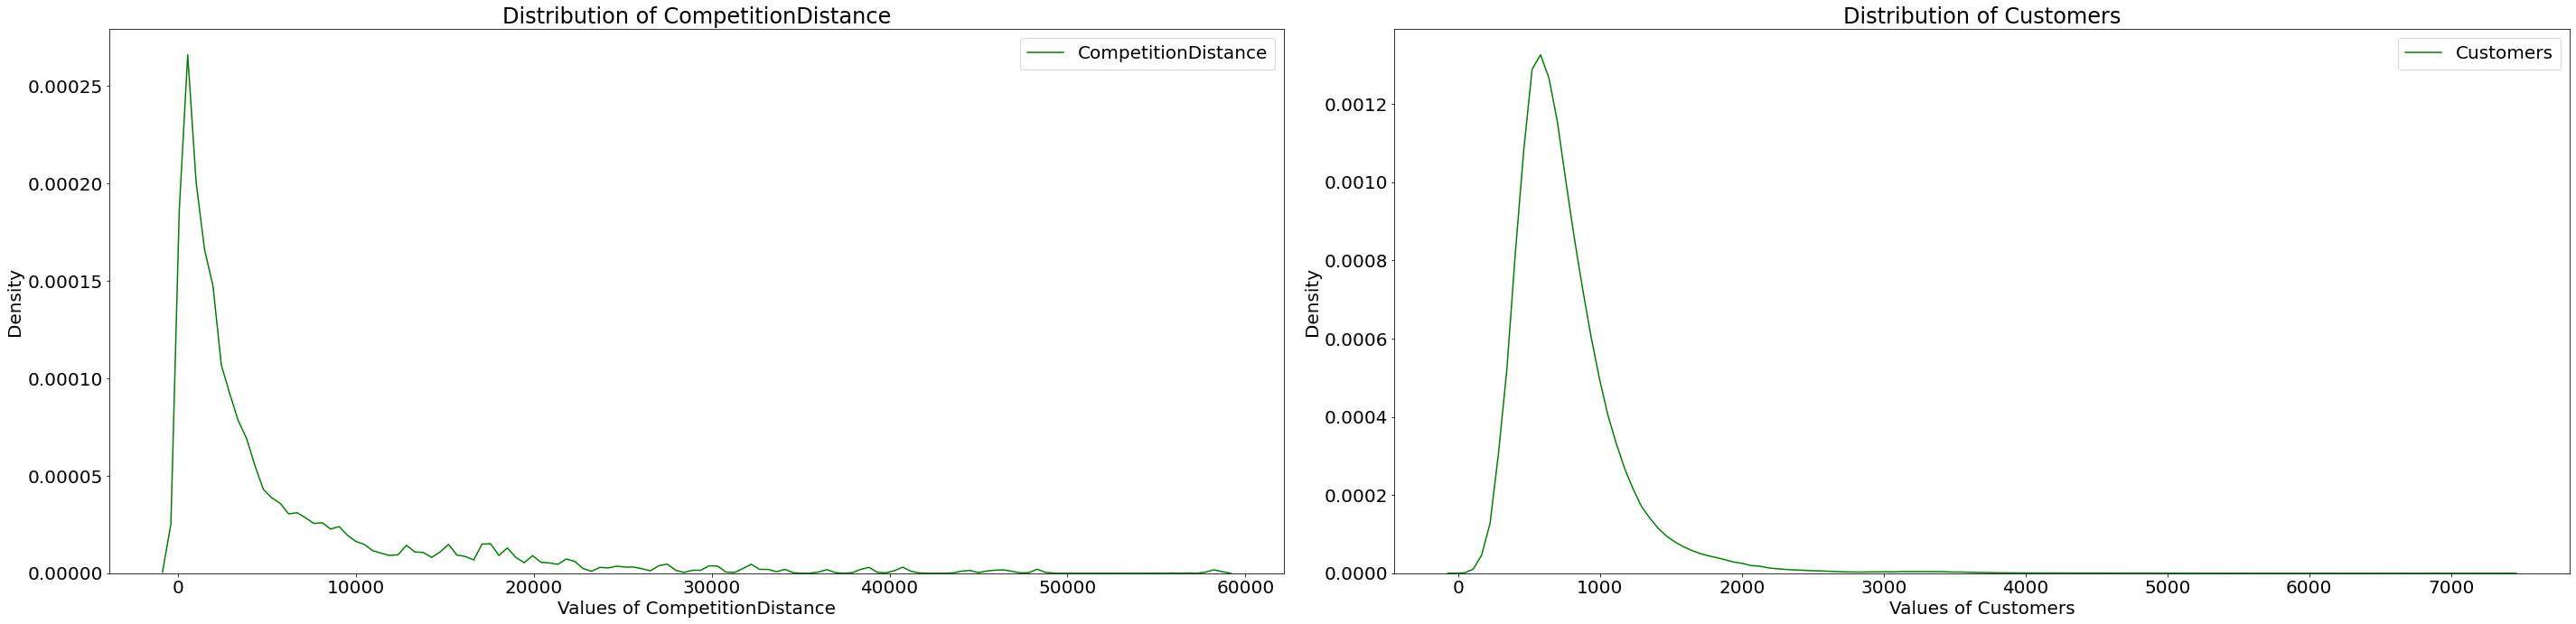

In [11]:
# check numerical features' distributions
plot_num_cols_distribution(df[num_cols], n_rows=1, n_cols=2, figsize=(40, 10))

In [12]:
num_cols_dist = get_num_cols_percentile(df[num_cols])
num_cols_dist

,col,min,perct1,perct5,perct25,perct50,perct75,perct90,perct99,perct99.9,max
1,CompetitionDistance,30,40,140,720,2230,6470,15710,38710,58260,58260
2,Customers,0,0,0,401,613,845,1130,2079,3562.28,7388


## Feature vs Target

In [57]:
def plot_num_col_target_distribution(df, target, condition_lst, color_lst, figsize=(20, 10)):
    plt.rcParams.update({'font.size': 20})
    fig=plt.figure(figsize=figsize)
    
    col = [col for col in df.columns if col != target][0]
    
    for j in range(len(condition_lst)):
        condition = condition_lst[j]
        color = color_lst[j]
            
        if j == 0:
            sns.kdeplot(df.loc[df[col]<condition][target], color='orange', label=f'{col} < {condition}', marker='*')
                
        if j < len(condition_lst) - 1:
            sns.kdeplot(df.loc[(df[col]>=condition) & (df[col] < condition_lst[j+1])][target], color=color, label=f'{condition} <= {col} < {condition_lst[j+1]}')
        else:
            sns.kdeplot(df.loc[(df[col]>=condition)][target], color=color, label=f'{condition} <= {col}')
                
        
        plt.legend(loc='best')
        plt.title(f'Distribution of {target} conditioned on {col}')
        plt.xlabel(f'Values of {target}')
        plt.ylabel('Density')
    fig.tight_layout()
    plt.show()
    
    
def plot_cat_col_target_distribution(df, target, n_rows, n_cols, figsize=(40, 20)):
    plt.rcParams.update({'font.size': 20})
    fig=plt.figure(figsize=figsize)
    
    i=0
    
    for feature in df.columns:
        if feature == target:
            continue
            
        i += 1
        ax=fig.add_subplot(n_rows,n_cols,i) 
        axes = plt.gca()
        condition_lst = df[feature].unique()
    
        for j in range(len(condition_lst)):
            condition = condition_lst[j]
            try:
                sns.kdeplot(df.loc[df[feature]==condition][target], 
                        color='#%06X' % random.randint(0, 0xFFFFFF), linewidth = 2,
                        label=f'{feature} = {condition}')
            except RuntimeError as re:
                if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                    sns.kdeplot(df.loc[df[feature]==condition][target], 
                        color='#%06X' % random.randint(0, 0xFFFFFF), linewidth = 2,
                        label=f'{feature} = {condition}', cumulative=True, bw=1.5)
                else:
                    raise re

            plt.legend(loc='best')
            plt.title(f'Distribution of {target} conditioned on {feature}')
            plt.xlabel(f'Values of {target}')
            plt.ylabel('Density')
    fig.tight_layout()
    plt.show()

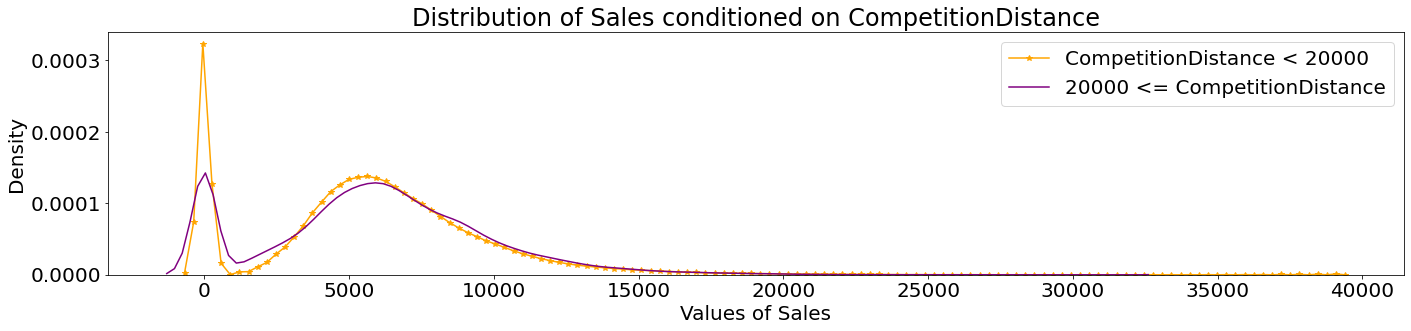

In [15]:
plot_num_col_target_distribution(df[['CompetitionDistance', 'Sales']], target='Sales', 
                                 condition_lst=[20000], color_lst=['purple'],  figsize=(20, 5))

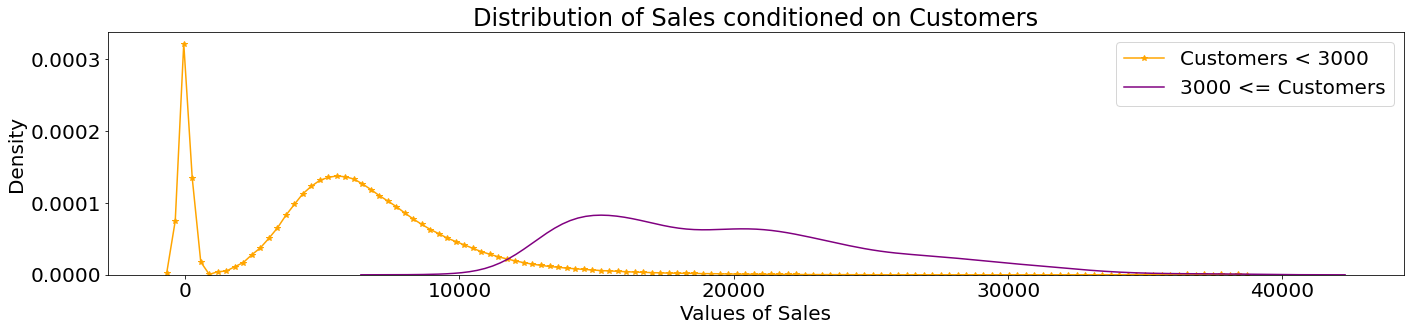

In [16]:
plot_num_col_target_distribution(df[['Customers', 'Sales']], target='Sales', 
                                 condition_lst=[3000], color_lst=['purple'],  figsize=(20, 5))

C:\Users\wuhan\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


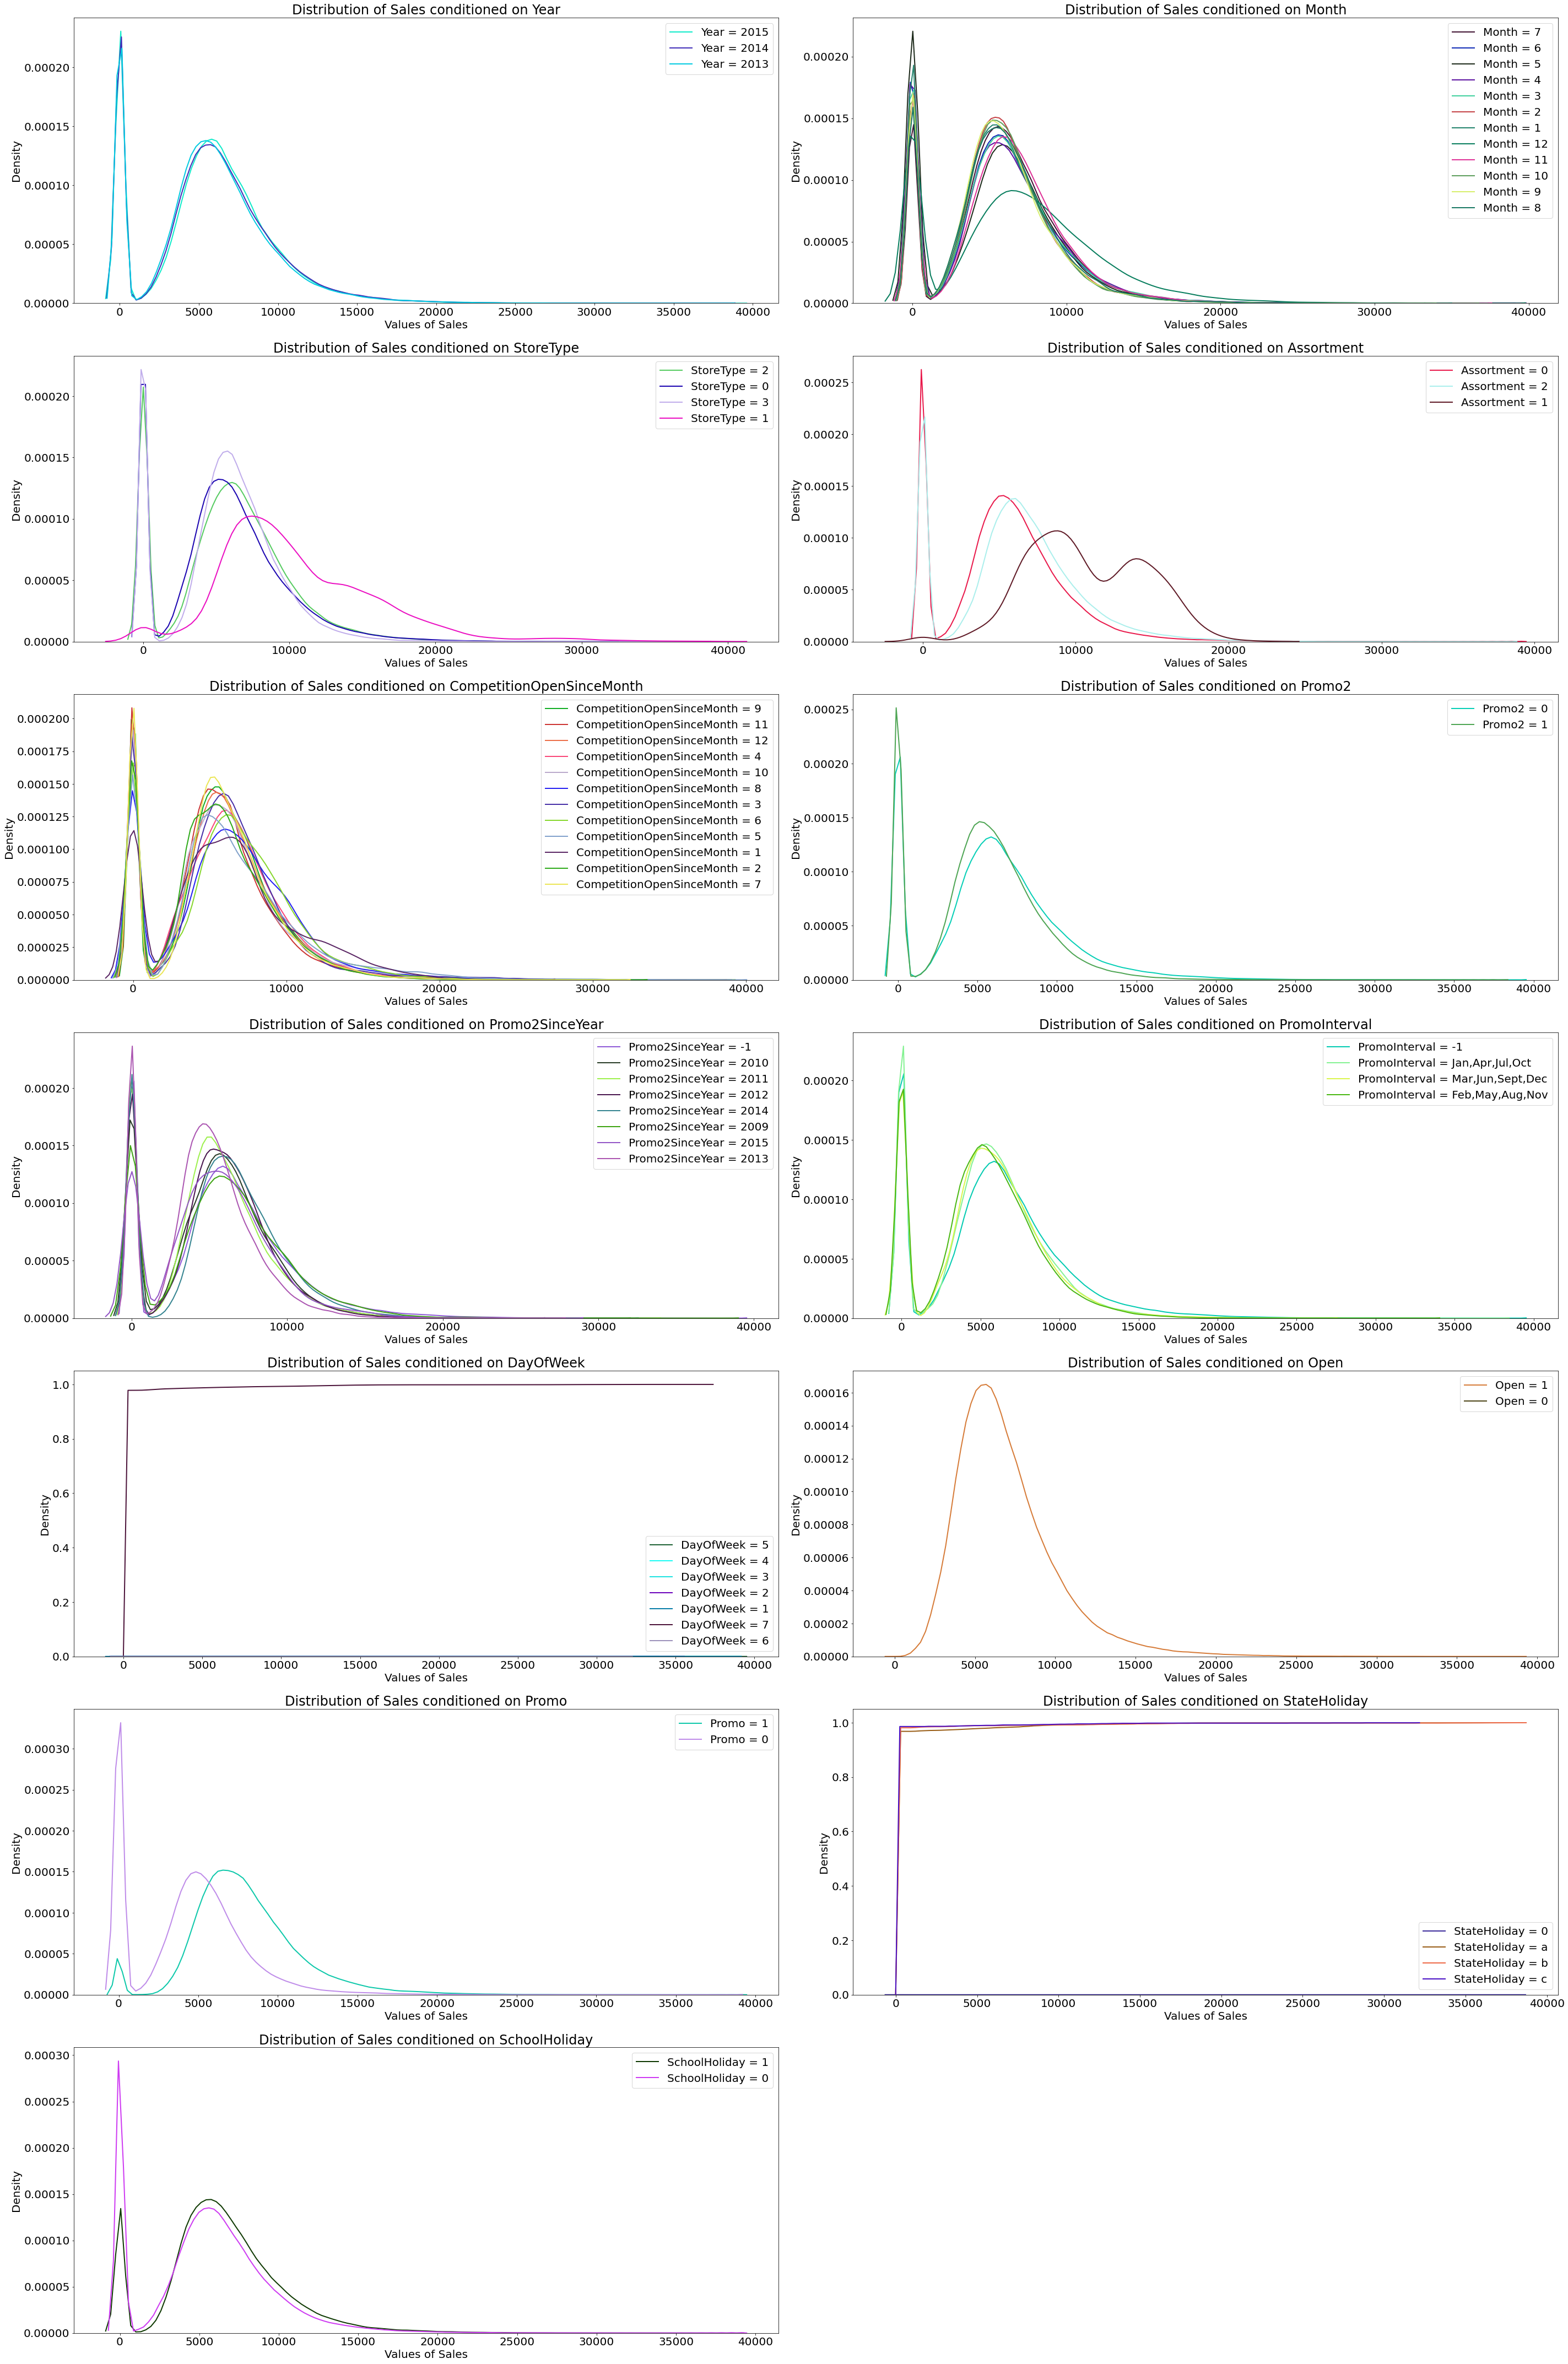

In [59]:
high_cat_cols = [col for col in cat_cols if df[col].nunique() > 12]  # exclude categorical features that with too many uniue values
new_cat_cols = [col for col in cat_cols if col not in high_cat_cols]
plot_cat_col_target_distribution(df[new_cat_cols+['Sales']], target='Sales', n_rows=len(new_cat_cols)//2 + 1, n_cols=2, figsize=(40, 60))

In [74]:
month_sales_dict = {}

for month in range(1, 13):
    month_sales_dist = get_num_cols_percentile(df.loc[df['Month']==month][['Sales']])
    month_sales_dict[month] = {k: v[1] for k, v in month_sales_dist.to_dict().items()}
    
month_sales_df = pd.DataFrame(month_sales_dict).T
month_sales_df

,col,min,perct1,perct5,perct25,perct50,perct75,perct90,perct99,perct99.9,max
1,Sales,0,0,0,3559,5489,7502.25,9710,15738.7,22149,32263
2,Sales,0,0,0,3809,5610,7551,9801,16005.8,22947.8,31649
3,Sales,0,0,0,3654,5755,7922,10468.8,16975.2,24099.4,36227
4,Sales,0,0,0,3562,5717,7964,10499,17127.2,24403.9,38722
5,Sales,0,0,0,2846,5703,7842,10177.8,16552.1,24089.3,38484
6,Sales,0,0,0,3643,5729,7884,10435,17209.7,24630.5,38037
7,Sales,0,0,0,4101,5942,8041.75,10428,16812.2,23248.5,32671
8,Sales,0,0,0,3762.5,5655,7666,9959.4,16000.5,22406.8,33913
9,Sales,0,0,0,3680,5510,7478.75,9784.1,15953.8,22034.2,32926
10,Sales,0,0,0,3700.5,5561,7484.5,9677,15690.9,22475.6,35702


### Insights

* When it's Sunday or StateHoliday, there's no sales
* When there is promotion, there shows higher sales
* December tend to have larger sales (longer tail in sales distribution)
* School Holidays shows a little bit more sales